In [ ]:
# Import required packages
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

**Data Collection**

In [ ]:
# Examples of Canadian finance ticker symbols
symbols_example = ["RY.TO", "TD.TO", "BNS.TO", "CM.TO"]

# Prompt the user for a ticker symbol
print("Please enter a Canadian finance ticker symbol.")
print("For example:", ", ".join(symbols_example))

company_name = input("Enter the ticker symbol of a company: ")

Please enter a Canadian finance ticker symbol.
For example: RY.TO, TD.TO, BNS.TO, CM.TO
Enter the ticker symbol of a company: TD.TO


In [ ]:
# Define the start and end dates for the stock data
end_date = datetime.now()
start_date = datetime(end_date.year - 15, end_date.month, end_date.day)

# Define the output file name
output_file = "stock_data.csv"





In [ ]:
# Fetch the stock data using the user-provided ticker symbol and date range
stock_data = yf.download(company_name, start=start_date, end=end_date)

# Print the first few rows of the stock data
print(stock_data)

# Add the date column to the DataFrame
stock_data['Date'] = stock_data.index




[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2008-07-31  30.520000  31.485001  30.260000  31.145000  17.441647  7346400
2008-08-01  31.305000  31.500000  30.514999  30.950001  17.332447  4520200
2008-08-05  30.895000  31.770000  30.690001  31.655001  17.727257  4275400
2008-08-06  31.385000  31.840000  31.165001  31.775000  17.794458  3688400
2008-08-07  31.250000  31.735001  30.860001  30.940001  17.326847  4568200
...               ...        ...        ...        ...        ...      ...
2023-07-24  86.050003  86.699997  85.750000  86.320000  86.320000  5635000
2023-07-25  86.650002  86.660004  84.940002  85.230003  85.230003  4336800
2023-07-26  85.019997  86.190002  85.019997  86.000000  86.000000  4591000
2023-07-27  86.160004  86.580002  85.680000  85.900002  85.900002  4040700
2023-07-28  86.500000  86.76000

**Data Cleaning Check**

In [ ]:
# Data Cleaning Checks
missing_values = stock_data.isnull().sum()
if missing_values.sum() > 0:
    print("Missing values found in the data.")
    print("Total number of missing values:", missing_values.sum())
    print("\nMissing values in each column:")
    print(missing_values[missing_values > 0])
else:
    print("No missing values found in the data.")

duplicates_count = stock_data.duplicated().sum()
if duplicates_count > 0:
    print("Duplicate data found in the data.")
    print("Number of duplicate rows:", duplicates_count)
else:
    print("No duplicate data found in the data.")

# Data Cleaning Step 3: Checking for Negative or Zero Values (for numerical columns)
numerical_columns = stock_data.select_dtypes(include=[np.number]).columns
negative_or_zero_values_count = (stock_data[numerical_columns] <= 0).sum().sum()
if negative_or_zero_values_count > 0:
    print("Negative or zero values found in the data.")
    print("Total number of negative or zero values:", negative_or_zero_values_count)
else:
    print("No negative or zero values found in the data.")


No missing values found in the data.
No duplicate data found in the data.
No negative or zero values found in the data.


In [ ]:
print(stock_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3762 entries, 2008-07-31 to 2023-07-28
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Open       3762 non-null   float64       
 1   High       3762 non-null   float64       
 2   Low        3762 non-null   float64       
 3   Close      3762 non-null   float64       
 4   Adj Close  3762 non-null   float64       
 5   Volume     3762 non-null   int64         
 6   Date       3762 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 235.1 KB
None


**Data Preparation**

In [ ]:
# Save the stock data to a CSV file
stock_data.to_csv(output_file, index=False)

# Print a confirmation message
print("Stock data saved to", output_file)


Stock data saved to stock_data.csv


In [ ]:
import pandas as pd

def check_missing_stock_data(stock_data, start_date, end_date):
    # Generate a complete date range for the specified date range
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')

    # Compare the date range with the retrieved stock data's index (dates) to find missing dates
    missing_dates = date_range[~date_range.isin(stock_data.index)]

    return missing_dates

if __name__ == "__main__":
    # Assuming you already have the stock_data DataFrame
    # Replace the following line with how you have obtained the stock_data DataFrame
    stock_data = pd.read_csv('/content/stock_data.csv', parse_dates=['Date'], index_col='Date')
    # Or, if your DataFrame already has the correct structure, you can simply assign it like this:
    # stock_data = your_existing_stock_data_dataframe

    end_date = datetime.now()
    start_date = datetime(end_date.year - 15, end_date.month, end_date.day)

    missing_dates = check_missing_stock_data(stock_data, start_date, end_date)
    print("Missing dates in stock data:")
    print(missing_dates)

Missing dates in stock data:
DatetimeIndex(['2008-08-02', '2008-08-03', '2008-08-04', '2008-08-09',
               '2008-08-10', '2008-08-16', '2008-08-17', '2008-08-23',
               '2008-08-24', '2008-08-30',
               ...
               '2023-07-03', '2023-07-08', '2023-07-09', '2023-07-15',
               '2023-07-16', '2023-07-22', '2023-07-23', '2023-07-29',
               '2023-07-30', '2023-07-31'],
              dtype='datetime64[ns]', length=1717, freq=None)


**EXplanatory Data Analysis**

In [ ]:
# Calculate and print some statistics
statistics = {
    "Mean Close Price": stock_data["Close"].mean(),
    "Maximum Volume": stock_data["Volume"].max(),
    "Minimum Low Price": stock_data["Low"].min(),
    "Total Trading Days": len(stock_data),
}
for key, value in statistics.items():
    print(f"{key}: {value}")


Mean Close Price: 57.878850323414945
Maximum Volume: 28929400
Minimum Low Price: 16.184999465942383
Total Trading Days: 3762


**Closing Price**

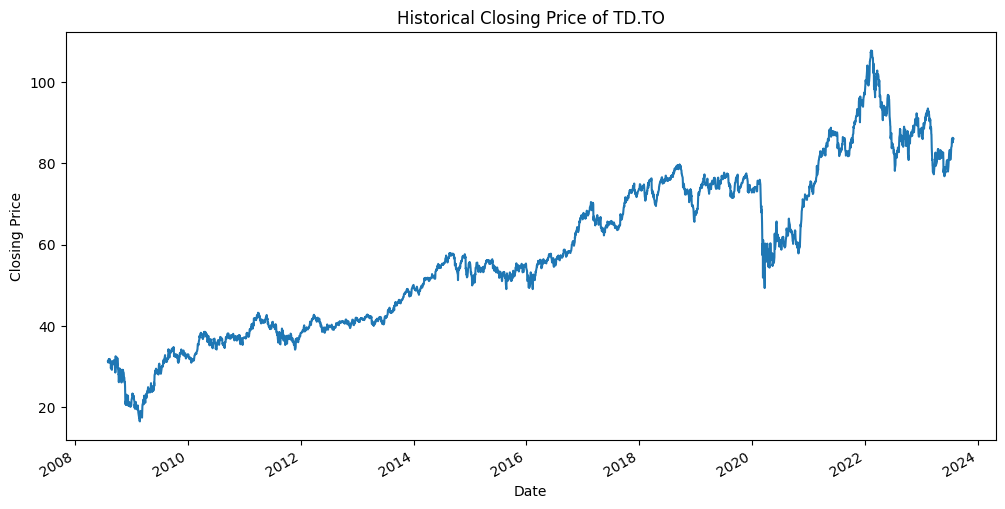

In [ ]:
# Plotting the historical view of the closing price
plt.figure(figsize=(12, 6))
stock_data['Close'].plot()
plt.title(f"Historical Closing Price of {company_name}")
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()



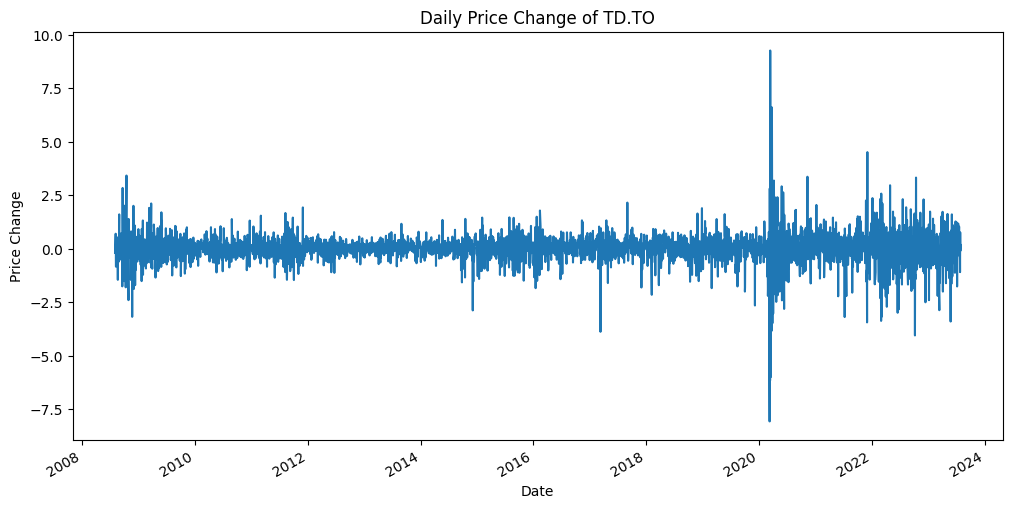

Overall price change: 54.94 CAD
Average daily price change: 0.01 CAD


In [ ]:
# Calculate the daily price change (price difference from the previous day)
stock_data['Price_Change'] = stock_data['Close'].diff()

# Plot the daily price change
plt.figure(figsize=(12, 6))
stock_data['Price_Change'].plot()
plt.title(f"Daily Price Change of {company_name}")
plt.xlabel('Date')
plt.ylabel('Price Change')
plt.show()

# Calculate and print the overall price change over the entire period
overall_price_change = stock_data['Close'].iloc[-1] - stock_data['Close'].iloc[0]
print(f"Overall price change: {overall_price_change:.2f} CAD")

# Calculate and print the average daily price change
average_daily_price_change = stock_data['Price_Change'].mean()
print(f"Average daily price change: {average_daily_price_change:.2f} CAD")

**Volume of Sales**

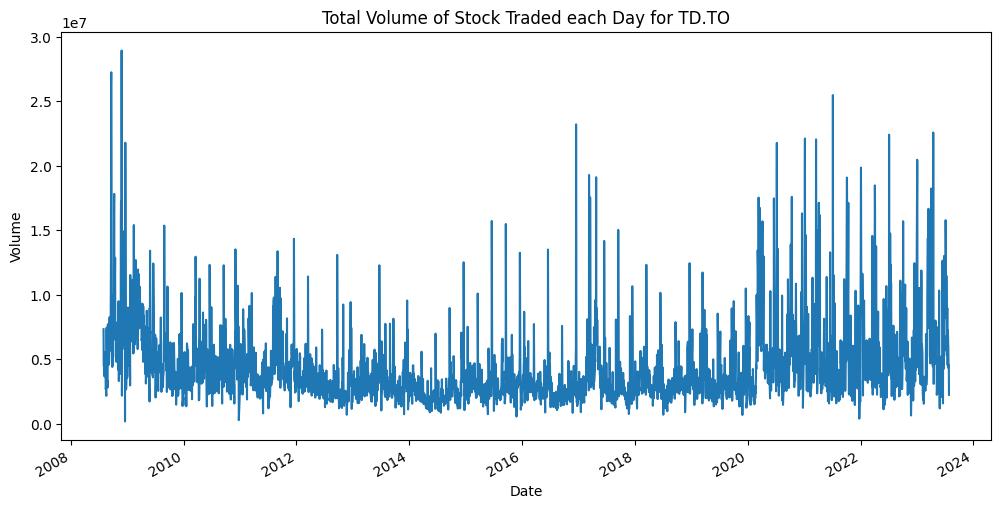

In [ ]:
# Plotting the total volume of stock being traded each day
plt.figure(figsize=(12, 6))
stock_data['Volume'].plot()
plt.title(f"Total Volume of Stock Traded each Day for {company_name}")
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

In [ ]:
# Calculate different important parameters of volume
average_daily_volume = stock_data['Volume'].mean()
maximum_daily_volume = stock_data['Volume'].max()
minimum_daily_volume = stock_data['Volume'].min()
total_volume = stock_data['Volume'].sum()



# Print the calculated parameters
print("Average Daily Volume:", average_daily_volume)
print("Maximum Daily Volume:", maximum_daily_volume)
print("Minimum Daily Volume:", minimum_daily_volume)
print("Total Volume:", total_volume)



Average Daily Volume: 4252364.832535885
Maximum Daily Volume: 28929400
Minimum Daily Volume: 200400
Total Volume: 15997396500


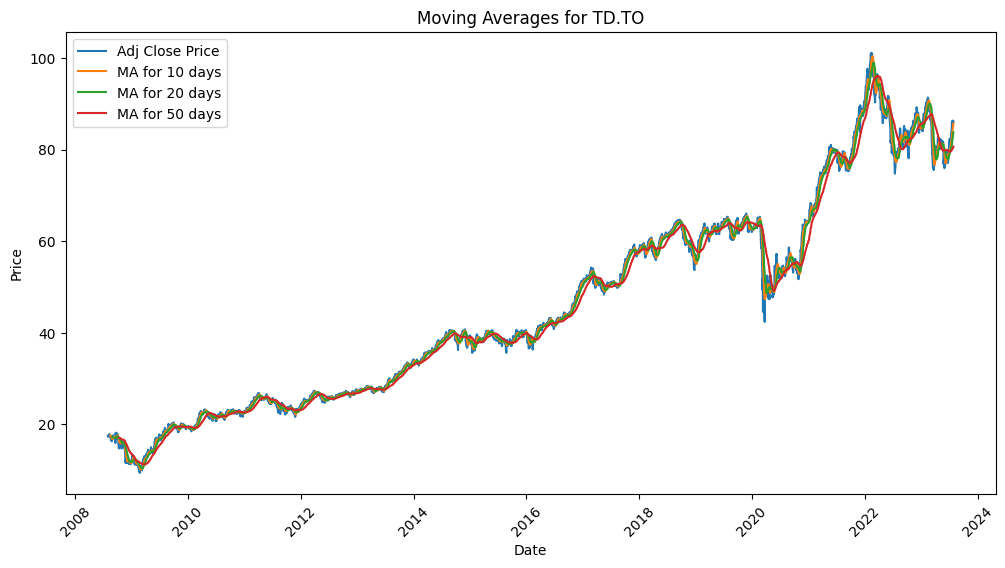

In [ ]:
ma_day = [10, 20, 50]
# Calculate moving averages for the stock data
for ma in ma_day:
    column_name = f"MA for {ma} days"
    stock_data[column_name] = stock_data['Adj Close'].rolling(ma).mean()

# Increase the size of the plot
plt.figure(figsize=(12, 6))  # Adjust width and height as needed

# Plotting the stock data with moving averages
plt.plot(stock_data.index, stock_data['Adj Close'], label='Adj Close Price')
for ma in ma_day:
    column_name = f"MA for {ma} days"
    plt.plot(stock_data.index, stock_data[column_name], label=column_name)

plt.title(f"Moving Averages for {company_name}")
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.show()

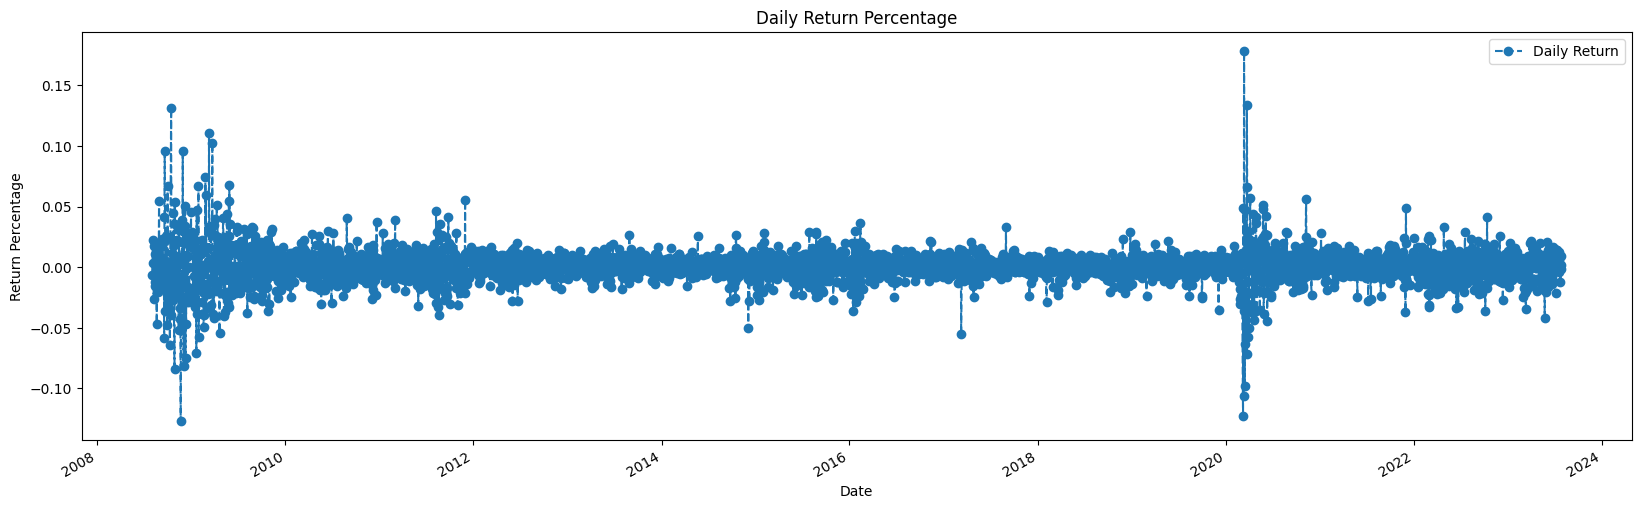

In [ ]:

# Calculate the daily return for the stock data
stock_data['Daily Return'] = stock_data['Adj Close'].pct_change()

# Plot the daily return percentage
fig, ax = plt.subplots(figsize=(20, 6))
stock_data['Daily Return'].plot(ax=ax, legend=True, linestyle='--', marker='o')
ax.set_title('Daily Return Percentage')
ax.set_xlabel('Date')
ax.set_ylabel('Return Percentage')
plt.show()
fig.tight_layout()

In [ ]:
stock_data['Daily_Return'] = stock_data['Adj Close'].pct_change()
# Calculate statistics for daily returns
mean_daily_return = stock_data['Daily_Return'].mean()
std_daily_return = stock_data['Daily_Return'].std()
min_daily_return = stock_data['Daily_Return'].min()
max_daily_return = stock_data['Daily_Return'].max()

# Display the statistics
print("Statistics for Daily Returns:")
print("----------------------------")
print("Mean Daily Return:", mean_daily_return)
print("Standard Deviation of Daily Returns:", std_daily_return)
print("Minimum Daily Return:", min_daily_return)
print("Maximum Daily Return:", max_daily_return)


Statistics for Daily Returns:
----------------------------
Mean Daily Return: 0.000520923771750291
Standard Deviation of Daily Returns: 0.013911615932548931
Minimum Daily Return: -0.1273783961294479
Maximum Daily Return: 0.1788196640606292


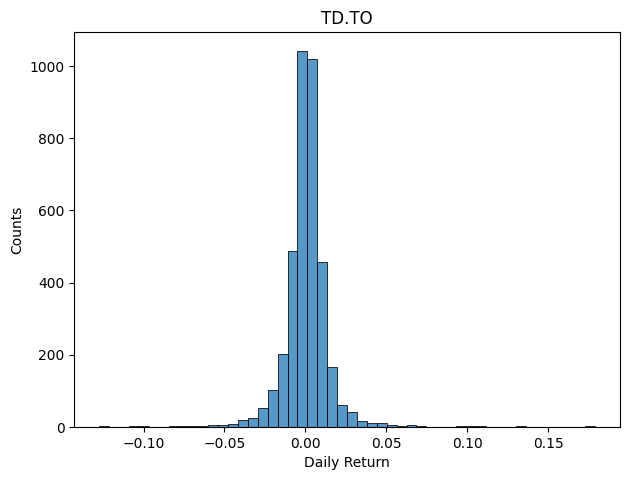

In [ ]:


plt.figure(figsize=(12, 9))

plt.subplot(2, 2, 1)
sns.histplot(data=stock_data, x='Daily Return', bins=50)
plt.xlabel('Daily Return')
plt.ylabel('Counts')
plt.title(f'{company_name}')

plt.tight_layout()
plt.show()

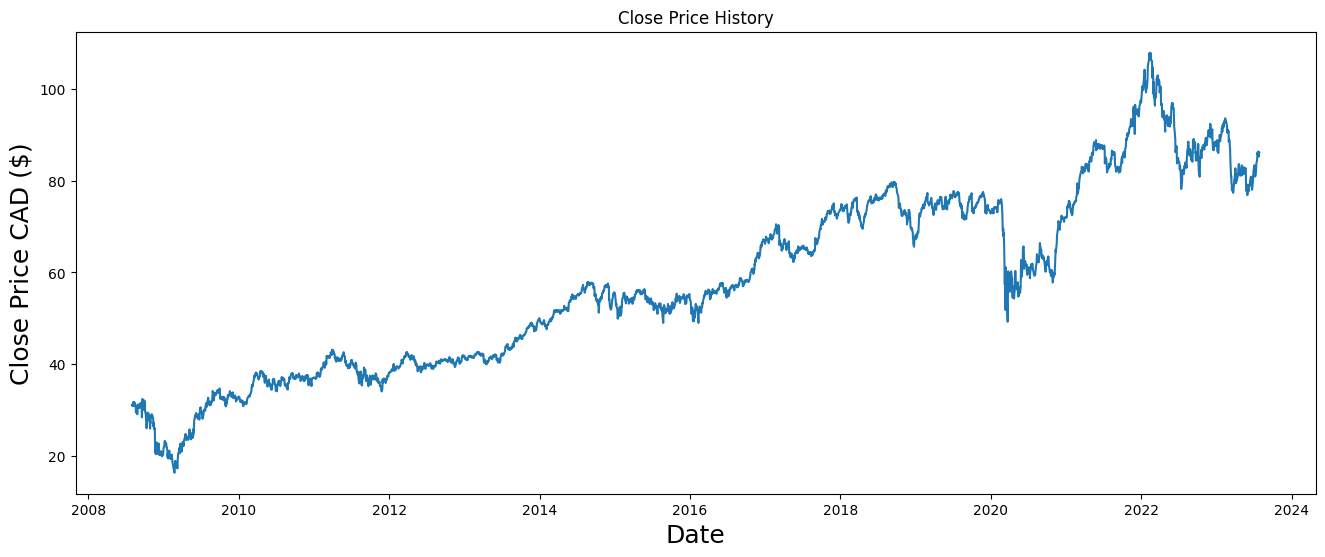

In [ ]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(stock_data['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price CAD ($)', fontsize=18)
plt.show()

In [ ]:
# Create a new dataframe with only the 'Close column
data = stock_data.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

print(training_data_len)

3574


In [ ]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))

print("Scaled Data:")
print(scaled_data)

Scaled Data:
[[0.1612533 ]
 [0.15912075]
 [0.16683073]
 ...
 [0.76115489]
 [0.76006129]
 [0.7620298 ]]


In [ ]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)

[array([0.1612533 , 0.15912075, 0.16683073, 0.16814305, 0.15901139,
       0.16491689, 0.16858051, 0.16442476, 0.1589567 , 0.16480753,
       0.16180009, 0.15912075, 0.14326335, 0.14725504, 0.1448491 ,
       0.14572399, 0.1391623 , 0.13938103, 0.14512249, 0.16272968,
       0.16037841, 0.15748032, 0.16032371, 0.15485565, 0.15387139,
       0.16169073, 0.15862863, 0.16595584, 0.1643154 , 0.1612533 ,
       0.1558399 , 0.15097332, 0.13178042, 0.14463037, 0.17574368,
       0.16289371, 0.16475286, 0.16458882, 0.17333772, 0.16551838,
       0.14900482, 0.17104114, 0.1634952 , 0.15146545, 0.14561462,
       0.13779528, 0.12696852, 0.12740595, 0.10772092, 0.10575241,
       0.14320868, 0.13057744, 0.13013998, 0.13369423, 0.14041995,
       0.13260062, 0.12412512, 0.13779528, 0.1312336 , 0.10498688])]
[0.12024279564421131]

[array([0.1612533 , 0.15912075, 0.16683073, 0.16814305, 0.15901139,
       0.16491689, 0.16858051, 0.16442476, 0.1589567 , 0.16480753,
       0.16180009, 0.15912075, 0.14

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(x_train, y_train, batch_size=1, epochs=15, validation_split=0.1, callbacks=[early_stopping])



Epoch 1/15
3162/3162 [==============================] - 143s 44ms/step - loss: 5.4196e-04 - val_loss: 2.9416e-04
Epoch 2/15
3162/3162 [==============================] - 139s 44ms/step - loss: 2.3271e-04 - val_loss: 4.2468e-04
Epoch 3/15
3162/3162 [==============================] - 138s 44ms/step - loss: 1.9596e-04 - val_loss: 7.1824e-04
Epoch 4/15
3162/3162 [==============================] - 145s 46ms/step - loss: 1.8341e-04 - val_loss: 1.4692e-04
Epoch 5/15
3162/3162 [==============================] - 139s 44ms/step - loss: 1.6287e-04 - val_loss: 0.0030
Epoch 6/15
3162/3162 [==============================] - 150s 47ms/step - loss: 1.4558e-04 - val_loss: 1.6160e-04
Epoch 7/15
3162/3162 [==============================] - 139s 44ms/step - loss: 1.2905e-04 - val_loss: 2.2487e-04
Epoch 8/15
3162/3162 [==============================] - 139s 44ms/step - loss: 1.3616e-04 - val_loss: 9.2390e-04
Epoch 9/15
3162/3162 [==============================] - 138s 44ms/step - loss: 1.1821e-04 - val_loss

In [ ]:
from sklearn.metrics import r2_score
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))

# Calculate R-squared value
r2 = r2_score(y_test, predictions)

# Print RMSE and R-squared value
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared Value:", r2)


188
6/6 [==============================] - 1s 73ms/step
Root Mean Squared Error (RMSE): 0.9604215315353467
R-squared Value: 0.9581280359346216


<ipython-input-177-4756f851ef79>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



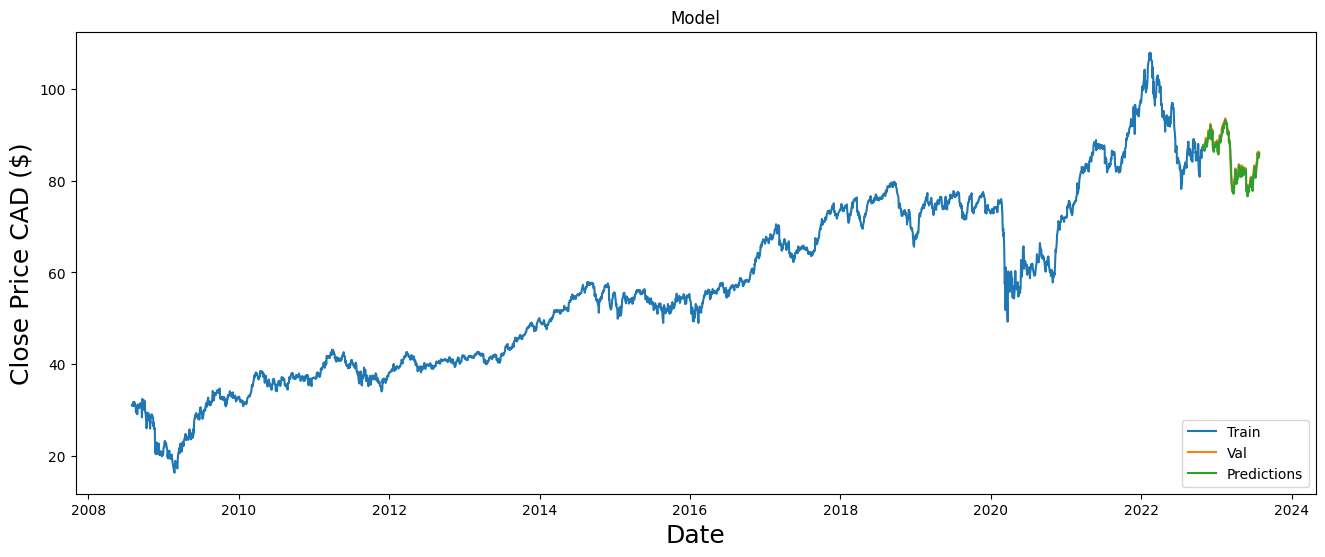

In [ ]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price CAD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

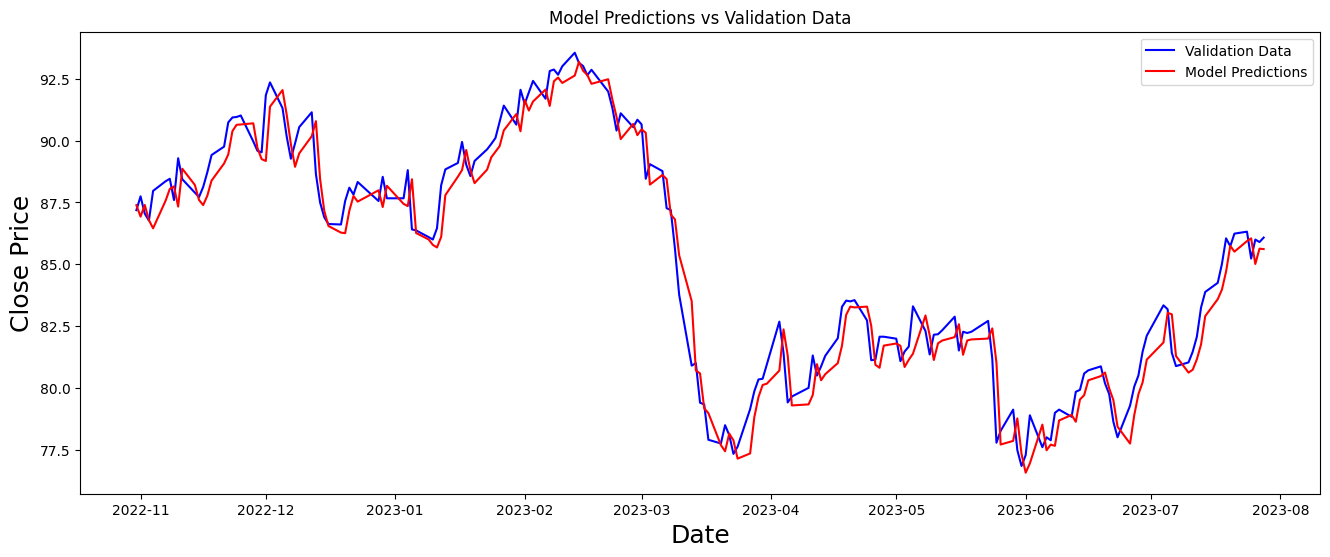

In [ ]:
import matplotlib.pyplot as plt

# Plot the data
plt.figure(figsize=(16, 6))
plt.title('Model Predictions vs Validation Data')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)

# Plot the validation data
plt.plot(valid.index, valid['Close'], label='Validation Data', color='blue')

# Plot the model predictions on the validation data
plt.plot(valid.index, valid['Predictions'], label='Model Predictions', color='red')

plt.legend()
plt.show()

In [ ]:
# Show the valid and predicted prices
print(valid)

                Close  Predictions
Date                              
2022-10-31  87.190002    87.391144
2022-11-01  87.750000    86.928558
2022-11-02  87.050003    87.401550
2022-11-03  86.769997    86.788757
2022-11-04  87.970001    86.455322
...               ...          ...
2023-07-24  86.320000    85.937309
2023-07-25  85.230003    86.048615
2023-07-26  86.000000    85.011154
2023-07-27  85.900002    85.632011
2023-07-28  86.080002    85.614342

[188 rows x 2 columns]
